In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('market_data.csv', index_col=0, parse_dates=True)

print("="*60)
print("ОБЩАЯ ИНФОРМАЦИЯ")
print("="*60)
print(f"Размер: {df.shape}")
print(f"Период: {df.index.min().date()} - {df.index.max().date()}")
print(f"Всего пропусков: {df.isna().sum().sum():,} ({df.isna().sum().sum() / df.size * 100:.2f}%)")

# Пропуски по столбцам
missing_by_col = df.isna().sum().sort_values(ascending=False)
print(f"\n{'='*60}")
print("ПРОПУСКИ ПО СТОЛБЦАМ (топ-20 худших)")
print("="*60)
for col, cnt in missing_by_col.head(20).items():
    pct = cnt / len(df) * 100
    print(f"{col:20s}: {cnt:5d} пропусков ({pct:5.1f}%)")

# Пропуски по датам
missing_by_date = df.isna().sum(axis=1).sort_values(ascending=False)
print(f"\n{'='*60}")
print("ПРОПУСКИ ПО ДАТАМ (топ-10 худших дней)")
print("="*60)
for date, cnt in missing_by_date.head(10).items():
    pct = cnt / df.shape[1] * 100
    print(f"{date.date()}: {cnt:4d} пропусков ({pct:5.1f}%)")

# Столбцы с >50% пропусков
bad_cols = missing_by_col[missing_by_col > len(df) * 0.5]
print(f"\n{'='*60}")
print(f"СТОЛБЦЫ С >50% ПРОПУСКОВ: {len(bad_cols)} шт")
print("="*60)
print(list(bad_cols.index))

# Статистика по типам инструментов
forex = [c for c in df.columns if '=X' in c]
stocks = [c for c in df.columns if '=X' not in c]
print(f"\n{'='*60}")
print("СТАТИСТИКА ПО ТИПАМ")
print("="*60)
print(f"Акции: {len(stocks)} | Avg пропусков: {df[stocks].isna().sum().mean():.1f}")
print(f"Валюты: {len(forex)} | Avg пропусков: {df[forex].isna().sum().mean():.1f}")


ОБЩАЯ ИНФОРМАЦИЯ
Размер: (1304, 537)
Период: 2020-11-30 - 2025-11-29
Всего пропусков: 28,105 (4.01%)

ПРОПУСКИ ПО СТОЛБЦАМ (топ-20 худших)
GEV                 :   883 пропусков ( 67.7%)
SOLV                :   882 пропусков ( 67.6%)
VLTO                :   763 пропусков ( 58.5%)
KVUE                :   658 пропусков ( 50.5%)
GEHC                :   563 пропусков ( 43.2%)
CEG                 :   334 пропусков ( 25.6%)
COIN                :   140 пропусков ( 10.7%)
EXE                 :    97 пропусков (  7.4%)
ABNB                :    56 пропусков (  4.3%)
DASH                :    55 пропусков (  4.2%)
IPG                 :    49 пропусков (  3.8%)
DOW                 :    48 пропусков (  3.7%)
AVY                 :    48 пропусков (  3.7%)
SO                  :    48 пропусков (  3.7%)
FICO                :    48 пропусков (  3.7%)
VTRS                :    48 пропусков (  3.7%)
KHC                 :    48 пропусков (  3.7%)
IDXX                :    48 пропусков (  3.7%)
FAST           

In [3]:
# ============================================================================
# ЗАГРУЗКА И ОЧИСТКА ДАННЫХ
# ============================================================================

df = pd.read_csv('financial_data_v2/market_data.csv', index_col=0, parse_dates=True)

print("ИСХОДНЫЕ ДАННЫЕ")
print(f"Размер: {df.shape}")
print(f"Пропусков: {df.isna().sum().sum():,} ({df.isna().sum().sum() / df.size * 100:.2f}%)")

# ============================================================================
# ШАГ 1: Удаляем столбцы с >50% пропусков
# ============================================================================

threshold_col = 0.5  # 50%
missing_pct_by_col = df.isna().sum() / len(df)
cols_to_drop = missing_pct_by_col[missing_pct_by_col > threshold_col].index.tolist()

print(f"\n🗑️ Удаляем {len(cols_to_drop)} столбцов (>50% пропусков): {cols_to_drop}")
df = df.drop(columns=cols_to_drop)

# ============================================================================
# ШАГ 2: Удаляем даты с >50% пропусков (праздники, когда биржа закрыта)
# ============================================================================

threshold_date = 0.5  # 50%
missing_pct_by_date = df.isna().sum(axis=1) / df.shape[1]
dates_to_drop = missing_pct_by_date[missing_pct_by_date > threshold_date].index

print(f"🗑️ Удаляем {len(dates_to_drop)} дат (>50% пропусков)")
df = df.drop(index=dates_to_drop)

# ============================================================================
# ШАГ 3: Заполняем оставшиеся пропуски методом forward fill
# ============================================================================

missing_before = df.isna().sum().sum()
df = df.ffill()  # Forward fill - заполняем предыдущим значением

# Если в начале ряда есть NaN (нет предыдущего значения) - используем backward fill
df = df.bfill()

missing_after = df.isna().sum().sum()
print(f"✅ Заполнено {missing_before - missing_after:,} пропусков методом ffill/bfill")

# ============================================================================
# ИТОГОВАЯ СТАТИСТИКА
# ============================================================================

print(f"\n{'='*60}")
print("ИТОГОВЫЕ ДАННЫЕ")
print("="*60)
print(f"Размер: {df.shape[0]} строк × {df.shape[1]} столбцов")
print(f"Период: {df.index.min().date()} - {df.index.max().date()}")
print(f"Пропусков: {df.isna().sum().sum()}")

# Разбивка по типам
forex = [c for c in df.columns if '=X' in c]
stocks = [c for c in df.columns if '=X' not in c]
print(f"\nАкции: {len(stocks)} | Валюты: {len(forex)}")

# ============================================================================
# СОХРАНЕНИЕ ОЧИЩЕННЫХ ДАННЫХ
# ============================================================================

df.to_csv('financial_data_v2/market_data_clean.csv')
df.to_pickle('financial_data_v2/market_data_clean.pkl')

print(f"\n💾 Сохранено:")
print(f"   - financial_data_v2/market_data_clean.csv")
print(f"   - financial_data_v2/market_data_clean.pkl")


ИСХОДНЫЕ ДАННЫЕ
Размер: (1304, 537)
Пропусков: 28,105 (4.01%)

🗑️ Удаляем 4 столбцов (>50% пропусков): ['VLTO', 'GEV', 'KVUE', 'SOLV']
🗑️ Удаляем 48 дат (>50% пропусков)
✅ Заполнено 993 пропусков методом ffill/bfill

ИТОГОВЫЕ ДАННЫЕ
Размер: 1256 строк × 533 столбцов
Период: 2020-11-30 - 2025-11-28
Пропусков: 0

Акции: 498 | Валюты: 35

💾 Сохранено:
   - financial_data_v2/market_data_clean.csv
   - financial_data_v2/market_data_clean.pkl


# Correlation analysis

## Correlation calculation

📊 Loading data...
Assets: 533
Total pairs: 141,778
📌 Analyzing 141,778 pairs with 13 correlation measures...


Computing all measures: 100%|██████████| 141778/141778 [4:14:24<00:00,  9.29it/s]  



✅ Computed 141,778 pairs

TOP 25 PAIRS WITH HIDDEN NONLINEAR DEPENDENCE
(High Distance/HSIC/MI but Low Pearson/Spearman)
  Asset1   Asset2   Pearson  Distance     HSIC       MI  Hoeffding  Nonlinearity
     CEG TRYUSD=X -0.003960  0.137657 0.039713 0.203221   0.032134      0.196894
KWDUSD=X     GEHC -0.000893  0.059065 0.012953 0.206332   0.166893      0.177534
TRYUSD=X     GEHC  0.012406  0.161802 0.057989 0.217190   0.166877      0.175434
     CEG     GEHC  0.170295  0.190061 0.038647 0.317510   0.136902      0.147214
HUFUSD=X     NXPI -0.008149  0.063317 0.019648 0.160869   0.000355      0.145625
EURUSD=X        F  0.004075  0.048995 0.012015 0.137004  -0.000278      0.132930
DKKUSD=X     STLD  0.003292  0.048747 0.010771 0.134800  -0.000338      0.131508
KWDUSD=X     TMUS -0.005368  0.051620 0.014128 0.136125   0.000541      0.130757
KWDUSD=X      CEG -0.038155  0.071604 0.016067 0.183871   0.040227      0.123254
GBPUSD=X      HON  0.006011  0.065652 0.019943 0.135439   0.000194  

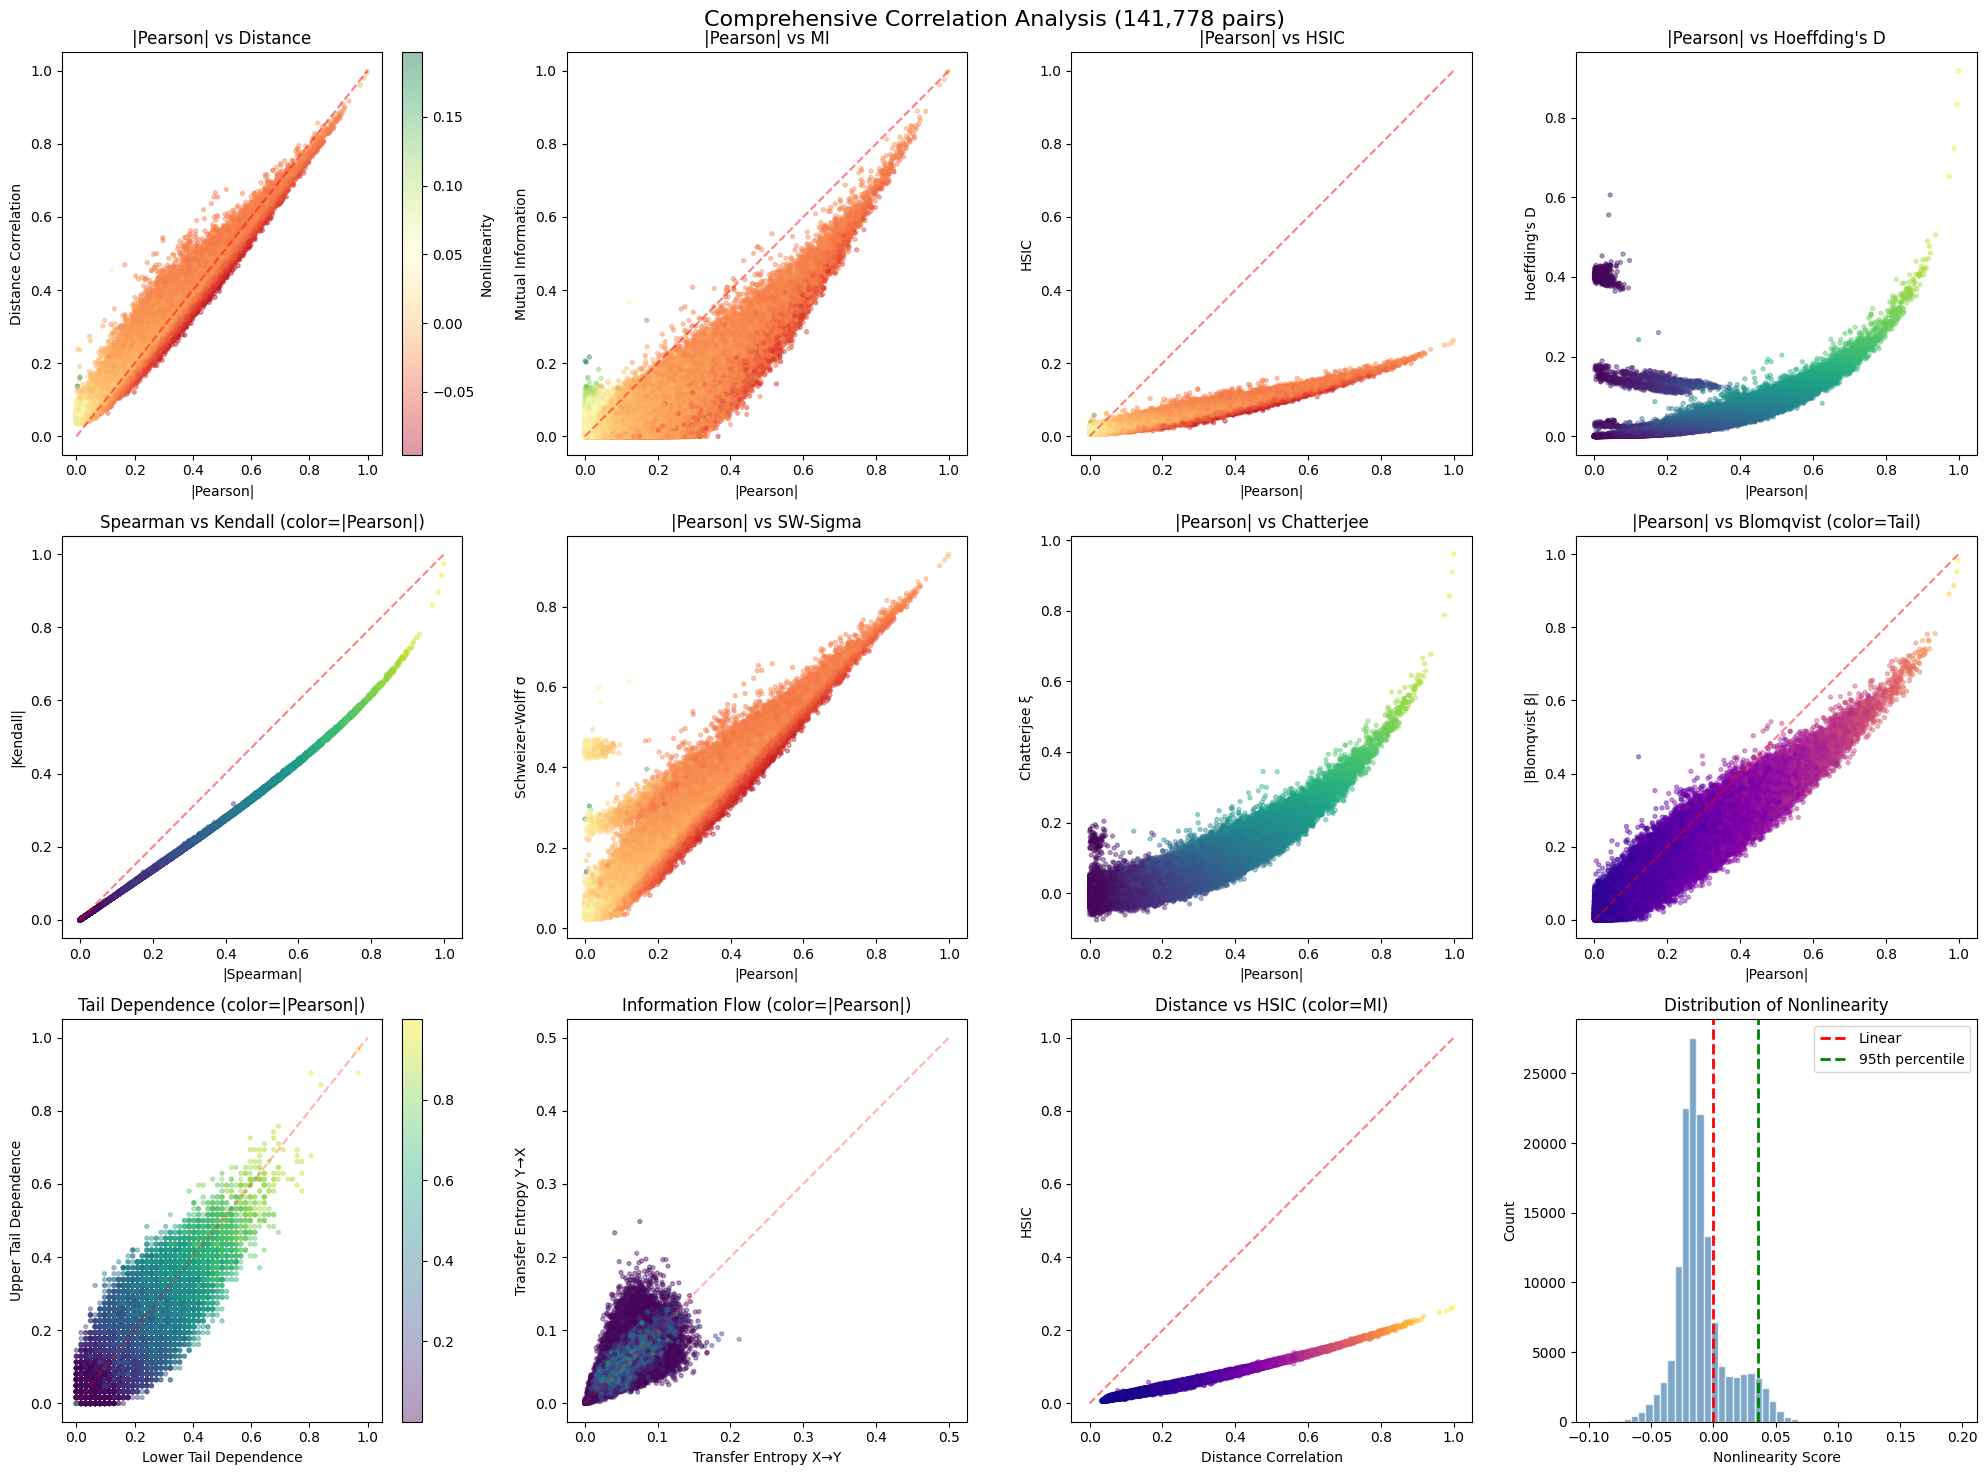

💾 Saved: comprehensive_correlation_analysis.png

CORRELATION BETWEEN DIFFERENT MEASURES


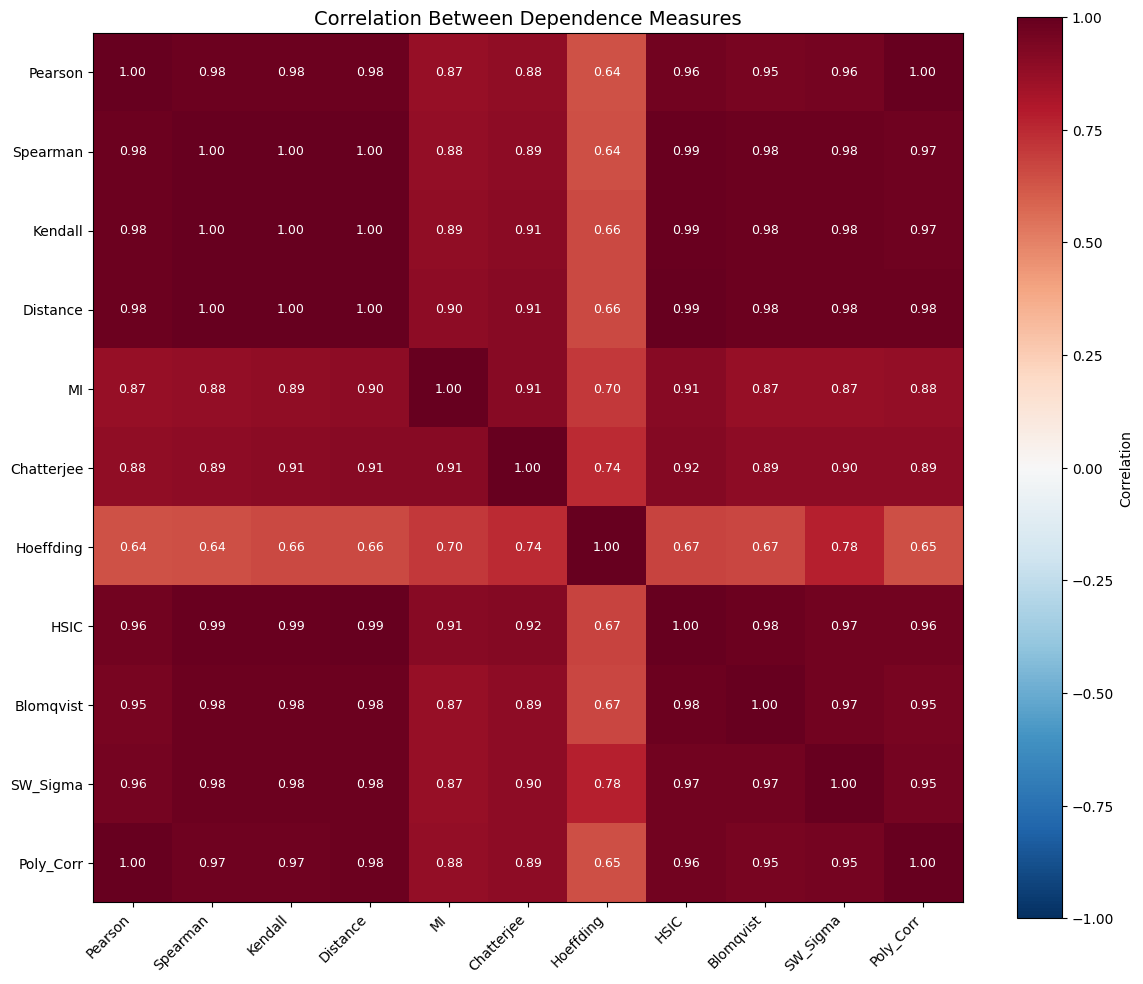

💾 Saved: measures_correlation_heatmap.png

STATISTICS BY MEASURE
Pearson     : mean= 0.2563, median= 0.2589, std= 0.1513, max= 0.9992
Spearman    : mean= 0.2731, median= 0.2826, std= 0.1554, max= 0.9989
Kendall     : mean= 0.1894, median= 0.1937, std= 0.1107, max= 0.9742
Distance    : mean= 0.2685, median= 0.2714, std= 0.1382, max= 0.9985
MI          : mean= 0.1146, median= 0.0942, std= 0.1033, max= 0.9986
Chatterjee  : mean= 0.0636, median= 0.0523, std= 0.0620, max= 0.9601
Hoeffding   : mean= 0.0337, median= 0.0243, std= 0.0411, max= 0.9180
HSIC        : mean= 0.0578, median= 0.0572, std= 0.0300, max= 0.2637
Blomqvist   : mean= 0.1946, median= 0.1987, std= 0.1118, max= 0.9824
SW_Sigma    : mean= 0.2604, median= 0.2670, std= 0.1392, max= 0.9303
Poly_Corr   : mean= 0.2601, median= 0.2592, std= 0.1460, max= 0.9992
Tail_Lower  : mean= 0.1845, median= 0.1774, std= 0.0873, max= 0.9677
Tail_Upper  : mean= 0.1691, median= 0.1613, std= 0.0866, max= 0.9677
TE_XY       : mean= 0.0504, median= 0.

In [31]:
# ============================================================================
# COMPREHENSIVE CORRELATION ANALYSIS - ALL METHODS
# Combines: Pearson, Spearman, Kendall, Distance, MI, Chatterjee,
#           Hoeffding, HSIC, Tail Dependence, Blomqvist, SW-Sigma,
#           Transfer Entropy, Polynomial Correlation
# ============================================================================

import pandas as pd
import numpy as np
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from sklearn.feature_selection import mutual_info_regression
from itertools import combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import dcor
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# ALL DEPENDENCE MEASURES
# ============================================================================

# 1. Chatterjee Xi
def chatterjee_xi(x, y):
    """Chatterjee's Xi - detects functional dependence."""
    n = len(x)
    order = np.argsort(x)
    y_sorted = np.array(y)[order]
    ranks = np.argsort(np.argsort(y_sorted)) + 1
    sum_diff = np.sum(np.abs(np.diff(ranks)))
    return 1 - (3 * sum_diff) / (n**2 - 1)

# 2. Mutual Information (normalized)
def mutual_info(x, y):
    """Normalized Mutual Information."""
    mi = mutual_info_regression(x.reshape(-1, 1), y, n_neighbors=3, random_state=42)[0]
    return np.clip(1 - np.exp(-2 * mi), 0, 1)

# 3. Hoeffding's D
def hoeffding_d(x, y):
    """Hoeffding's D - detects ANY departure from independence."""
    n = len(x)
    R = stats.rankdata(x)
    S = stats.rankdata(y)
    
    Q = np.zeros(n)
    for i in range(n):
        Q[i] = np.sum((x < x[i]) & (y < y[i]))
    
    D1 = np.sum((Q - 1) * (Q - 2))
    D2 = np.sum((R - 1) * (R - 2) * (S - 1) * (S - 2))
    D3 = np.sum((R - 2) * (S - 2) * (Q - 1))
    
    D = 30 * ((n - 2) * (n - 3) * D1 + D2 - 2 * (n - 2) * D3) / \
        (n * (n - 1) * (n - 2) * (n - 3) * (n - 4))
    return D

# 4. HSIC (Hilbert-Schmidt Independence Criterion)
def hsic(x, y):
    """HSIC - kernel-based independence measure."""
    n = len(x)
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    
    sigma_x = np.median(pdist(x, 'euclidean'))
    sigma_y = np.median(pdist(y, 'euclidean'))
    sigma_x = sigma_x if sigma_x > 0 else 1.0
    sigma_y = sigma_y if sigma_y > 0 else 1.0
    
    K = np.exp(-squareform(pdist(x, 'sqeuclidean')) / (2 * sigma_x ** 2))
    L = np.exp(-squareform(pdist(y, 'sqeuclidean')) / (2 * sigma_y ** 2))
    
    H = np.eye(n) - np.ones((n, n)) / n
    Kc = H @ K @ H
    Lc = H @ L @ H
    
    hsic_value = np.trace(Kc @ Lc) / ((n - 1) ** 2)
    return np.sqrt(max(0, hsic_value))

# 5. Tail Dependence
def tail_dependence(x, y, q=0.05):
    """Empirical tail dependence coefficients."""
    n = len(x)
    u = stats.rankdata(x) / (n + 1)
    v = stats.rankdata(y) / (n + 1)
    
    lower_mask = (u <= q) & (v <= q)
    lambda_lower = np.sum(lower_mask) / np.sum(u <= q) if np.sum(u <= q) > 0 else 0
    
    upper_mask = (u >= 1 - q) & (v >= 1 - q)
    lambda_upper = np.sum(upper_mask) / np.sum(u >= 1 - q) if np.sum(u >= 1 - q) > 0 else 0
    
    return lambda_lower, lambda_upper

# 6. Blomqvist's Beta
def blomqvist_beta(x, y):
    """Blomqvist's beta - medial correlation."""
    median_x, median_y = np.median(x), np.median(y)
    n_pp = np.sum((x > median_x) & (y > median_y))
    n_nn = np.sum((x < median_x) & (y < median_y))
    n_pn = np.sum((x > median_x) & (y < median_y))
    n_np = np.sum((x < median_x) & (y > median_y))
    total = n_pp + n_nn + n_pn + n_np
    return (n_pp + n_nn - n_pn - n_np) / total if total > 0 else 0

# 7. Schweizer-Wolff Sigma
def schweizer_wolff_sigma(x, y, n_grid=30):
    """Schweizer-Wolff sigma - copula-based."""
    n = len(x)
    u = stats.rankdata(x) / (n + 1)
    v = stats.rankdata(y) / (n + 1)
    
    grid = np.linspace(0, 1, n_grid)
    sigma = 0
    for s in grid:
        for t in grid:
            C_emp = np.mean((u <= s) & (v <= t))
            sigma += np.abs(C_emp - s * t)
    
    return 12 * sigma / (n_grid ** 2)

# 8. Transfer Entropy
def transfer_entropy(x, y, lag=1, bins=8):
    """Transfer Entropy X → Y."""
    y_t = y[lag:]
    y_lag = y[:-lag]
    x_lag = x[:-lag]
    
    y_t_d = pd.cut(y_t, bins=bins, labels=False)
    y_lag_d = pd.cut(y_lag, bins=bins, labels=False)
    x_lag_d = pd.cut(x_lag, bins=bins, labels=False)
    
    def entropy(labels):
        _, counts = np.unique(labels, return_counts=True)
        probs = counts / len(labels)
        return -np.sum(probs * np.log2(probs + 1e-10))
    
    def joint_entropy(*arrays):
        combined = np.column_stack(arrays)
        _, counts = np.unique(combined, axis=0, return_counts=True)
        probs = counts / len(combined)
        return -np.sum(probs * np.log2(probs + 1e-10))
    
    H_yt_ylag = joint_entropy(y_t_d, y_lag_d)
    H_ylag = entropy(y_lag_d)
    H_yt_ylag_xlag = joint_entropy(y_t_d, y_lag_d, x_lag_d)
    H_ylag_xlag = joint_entropy(y_lag_d, x_lag_d)
    
    TE = H_yt_ylag - H_ylag - H_yt_ylag_xlag + H_ylag_xlag
    return max(0, TE)

# 9. Polynomial Correlation
def polynomial_correlation(x, y, max_degree=3):
    """Maximum correlation with polynomial transformations."""
    max_corr = abs(np.corrcoef(x, y)[0, 1])
    for d in range(2, max_degree + 1):
        max_corr = max(max_corr, abs(np.corrcoef(x, y**d)[0, 1]))
        max_corr = max(max_corr, abs(np.corrcoef(x**d, y)[0, 1]))
    return max_corr

# ============================================================================
# LOAD DATA
# ============================================================================

print("📊 Loading data...")
df = pd.read_pickle('financial_data_v2/market_data_clean.pkl')
returns = df.pct_change().dropna()

columns = returns.columns.tolist()
n_cols = len(columns)
total_pairs = n_cols * (n_cols - 1) // 2

print(f"Assets: {n_cols}")
print(f"Total pairs: {total_pairs:,}")

# ============================================================================
# SAMPLE SELECTION
# ============================================================================

SAMPLE_SIZE = total_pairs  # Adjust based on your patience :)
np.random.seed(42)

all_pairs = [(i, j) for i in range(n_cols) for j in range(i+1, n_cols)]
sample_idx = np.random.choice(len(all_pairs), size=min(SAMPLE_SIZE, len(all_pairs)), replace=False)
pairs_to_analyze = [all_pairs[i] for i in sample_idx]

print(f"📌 Analyzing {len(pairs_to_analyze):,} pairs with 13 correlation measures...")

# ============================================================================
# COMPUTE ALL MEASURES
# ============================================================================

results = []

for i, j in tqdm(pairs_to_analyze, desc="Computing all measures"):
    col1, col2 = columns[i], columns[j]
    x = returns[col1].values
    y = returns[col2].values
    
    # Linear & Rank correlations
    pearson = np.corrcoef(x, y)[0, 1]
    spearman = stats.spearmanr(x, y)[0]
    kendall = stats.kendalltau(x, y)[0]
    
    # Nonlinear measures
    dist_corr = dcor.distance_correlation(x, y)
    mi = mutual_info(x, y)
    xi = chatterjee_xi(x, y)
    hoeff = hoeffding_d(x, y)
    hsic_val = hsic(x, y)
    blomq = blomqvist_beta(x, y)
    sw = schweizer_wolff_sigma(x, y)
    poly = polynomial_correlation(x, y)
    
    # Tail dependence
    tail_l, tail_u = tail_dependence(x, y)
    
    # Transfer entropy (both directions)
    te_xy = transfer_entropy(x, y)
    te_yx = transfer_entropy(y, x)
    
    results.append({
        'Asset1': col1,
        'Asset2': col2,
        'Pearson': pearson,
        'Spearman': spearman,
        'Kendall': kendall,
        'Distance': dist_corr,
        'MI': mi,
        'Chatterjee': xi,
        'Hoeffding': hoeff,
        'HSIC': hsic_val,
        'Blomqvist': blomq,
        'SW_Sigma': sw,
        'Poly_Corr': poly,
        'Tail_Lower': tail_l,
        'Tail_Upper': tail_u,
        'TE_XY': te_xy,
        'TE_YX': te_yx,
    })

df_corr = pd.DataFrame(results)

print(f"\n✅ Computed {len(df_corr):,} pairs")

# ============================================================================
# DERIVED METRICS
# ============================================================================

# Nonlinearity: high nonlinear measures but low linear
df_corr['Max_Linear'] = df_corr[['Pearson', 'Spearman', 'Kendall']].abs().max(axis=1)
df_corr['Max_Nonlinear'] = df_corr[['Distance', 'HSIC', 'MI']].max(axis=1)
df_corr['Nonlinearity'] = df_corr['Max_Nonlinear'] - df_corr['Max_Linear']

# Tail dependence average
df_corr['Tail_Avg'] = (df_corr['Tail_Lower'] + df_corr['Tail_Upper']) / 2

# Information flow asymmetry
df_corr['TE_Asymmetry'] = np.abs(df_corr['TE_XY'] - df_corr['TE_YX'])

# ============================================================================
# RESULTS SUMMARY
# ============================================================================

print("\n" + "="*90)
print("TOP 25 PAIRS WITH HIDDEN NONLINEAR DEPENDENCE")
print("(High Distance/HSIC/MI but Low Pearson/Spearman)")
print("="*90)

df_sorted = df_corr.sort_values('Nonlinearity', ascending=False)
cols = ['Asset1', 'Asset2', 'Pearson', 'Distance', 'HSIC', 'MI', 'Hoeffding', 'Nonlinearity']
print(df_sorted[cols].head(25).to_string(index=False))

print("\n" + "="*90)
print("TOP 20 PAIRS WITH HIGH TAIL DEPENDENCE (joint crashes/rallies)")
print("="*90)
df_tail = df_corr.sort_values('Tail_Avg', ascending=False)
print(df_tail[['Asset1', 'Asset2', 'Pearson', 'Tail_Lower', 'Tail_Upper', 'Tail_Avg']].head(20).to_string(index=False))

print("\n" + "="*90)
print("TOP 20 PAIRS WITH ASYMMETRIC INFORMATION FLOW")
print("="*90)
df_te = df_corr.sort_values('TE_Asymmetry', ascending=False)
print(df_te[['Asset1', 'Asset2', 'TE_XY', 'TE_YX', 'TE_Asymmetry', 'Pearson']].head(20).to_string(index=False))

# ============================================================================
# COMPREHENSIVE SCATTER PLOTS
# ============================================================================

print("\n📊 Creating comprehensive scatter plots...")

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle(f'Comprehensive Correlation Analysis ({len(df_corr):,} pairs)', fontsize=16)

# Row 1: Linear vs Nonlinear measures
ax = axes[0, 0]
sc = ax.scatter(df_corr['Pearson'].abs(), df_corr['Distance'], c=df_corr['Nonlinearity'], 
                cmap='RdYlGn', alpha=0.4, s=8)
ax.plot([0, 1], [0, 1], 'r--', alpha=0.5)
ax.set_xlabel('|Pearson|')
ax.set_ylabel('Distance Correlation')
ax.set_title('|Pearson| vs Distance')
plt.colorbar(sc, ax=ax, label='Nonlinearity')

ax = axes[0, 1]
ax.scatter(df_corr['Pearson'].abs(), df_corr['MI'], c=df_corr['Nonlinearity'], 
           cmap='RdYlGn', alpha=0.4, s=8)
ax.plot([0, 1], [0, 1], 'r--', alpha=0.5)
ax.set_xlabel('|Pearson|')
ax.set_ylabel('Mutual Information')
ax.set_title('|Pearson| vs MI')

ax = axes[0, 2]
ax.scatter(df_corr['Pearson'].abs(), df_corr['HSIC'], c=df_corr['Nonlinearity'], 
           cmap='RdYlGn', alpha=0.4, s=8)
ax.plot([0, 1], [0, 1], 'r--', alpha=0.5)
ax.set_xlabel('|Pearson|')
ax.set_ylabel('HSIC')
ax.set_title('|Pearson| vs HSIC')

ax = axes[0, 3]
ax.scatter(df_corr['Pearson'].abs(), df_corr['Hoeffding'], c=df_corr['Distance'], 
           cmap='viridis', alpha=0.4, s=8)
ax.set_xlabel('|Pearson|')
ax.set_ylabel("Hoeffding's D")
ax.set_title("|Pearson| vs Hoeffding's D")

# Row 2: Rank correlations and copula measures
ax = axes[1, 0]
ax.scatter(df_corr['Spearman'].abs(), df_corr['Kendall'].abs(), c=df_corr['Pearson'].abs(), 
           cmap='viridis', alpha=0.4, s=8)
ax.plot([0, 1], [0, 1], 'r--', alpha=0.5)
ax.set_xlabel('|Spearman|')
ax.set_ylabel('|Kendall|')
ax.set_title('Spearman vs Kendall (color=|Pearson|)')

ax = axes[1, 1]
ax.scatter(df_corr['Pearson'].abs(), df_corr['SW_Sigma'], c=df_corr['Nonlinearity'], 
           cmap='RdYlGn', alpha=0.4, s=8)
ax.set_xlabel('|Pearson|')
ax.set_ylabel('Schweizer-Wolff σ')
ax.set_title('|Pearson| vs SW-Sigma')

ax = axes[1, 2]
ax.scatter(df_corr['Pearson'].abs(), df_corr['Chatterjee'], c=df_corr['Distance'], 
           cmap='viridis', alpha=0.4, s=8)
ax.set_xlabel('|Pearson|')
ax.set_ylabel('Chatterjee ξ')
ax.set_title('|Pearson| vs Chatterjee')

ax = axes[1, 3]
ax.scatter(df_corr['Pearson'].abs(), df_corr['Blomqvist'].abs(), c=df_corr['Tail_Avg'], 
           cmap='plasma', alpha=0.4, s=8)
ax.plot([0, 1], [0, 1], 'r--', alpha=0.5)
ax.set_xlabel('|Pearson|')
ax.set_ylabel('|Blomqvist β|')
ax.set_title('|Pearson| vs Blomqvist (color=Tail)')

# Row 3: Tail dependence, Transfer Entropy, and distributions
ax = axes[2, 0]
sc = ax.scatter(df_corr['Tail_Lower'], df_corr['Tail_Upper'], c=df_corr['Pearson'].abs(), 
                cmap='viridis', alpha=0.4, s=8)
ax.plot([0, 1], [0, 1], 'r--', alpha=0.3)
ax.set_xlabel('Lower Tail Dependence')
ax.set_ylabel('Upper Tail Dependence')
ax.set_title('Tail Dependence (color=|Pearson|)')
plt.colorbar(sc, ax=ax)

ax = axes[2, 1]
sc = ax.scatter(df_corr['TE_XY'], df_corr['TE_YX'], c=df_corr['Pearson'].abs(), 
                cmap='viridis', alpha=0.4, s=8)
ax.plot([0, 0.5], [0, 0.5], 'r--', alpha=0.3)
ax.set_xlabel('Transfer Entropy X→Y')
ax.set_ylabel('Transfer Entropy Y→X')
ax.set_title('Information Flow (color=|Pearson|)')

ax = axes[2, 2]
ax.scatter(df_corr['Distance'], df_corr['HSIC'], c=df_corr['MI'], 
           cmap='plasma', alpha=0.4, s=8)
ax.plot([0, 1], [0, 1], 'r--', alpha=0.5)
ax.set_xlabel('Distance Correlation')
ax.set_ylabel('HSIC')
ax.set_title('Distance vs HSIC (color=MI)')

ax = axes[2, 3]
ax.hist(df_corr['Nonlinearity'], bins=50, color='steelblue', edgecolor='white', alpha=0.7)
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Linear')
ax.axvline(x=df_corr['Nonlinearity'].quantile(0.95), color='green', linestyle='--', 
           linewidth=2, label='95th percentile')
ax.set_xlabel('Nonlinearity Score')
ax.set_ylabel('Count')
ax.set_title('Distribution of Nonlinearity')
ax.legend()

plt.tight_layout()
plt.savefig('financial_data_v2/comprehensive_correlation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Saved: comprehensive_correlation_analysis.png")

# ============================================================================
# CORRELATION MATRIX BETWEEN MEASURES
# ============================================================================

print("\n" + "="*90)
print("CORRELATION BETWEEN DIFFERENT MEASURES")
print("="*90)

measures = ['Pearson', 'Spearman', 'Kendall', 'Distance', 'MI', 'Chatterjee', 
            'Hoeffding', 'HSIC', 'Blomqvist', 'SW_Sigma', 'Poly_Corr']

# Use absolute values for signed measures
corr_data = df_corr[measures].copy()
for col in ['Pearson', 'Spearman', 'Kendall', 'Blomqvist']:
    corr_data[col] = corr_data[col].abs()

measure_corr = corr_data.corr()

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(measure_corr.values, cmap='RdBu_r', vmin=-1, vmax=1)

ax.set_xticks(range(len(measures)))
ax.set_yticks(range(len(measures)))
ax.set_xticklabels(measures, rotation=45, ha='right')
ax.set_yticklabels(measures)

# Add correlation values
for i in range(len(measures)):
    for j in range(len(measures)):
        text = ax.text(j, i, f'{measure_corr.iloc[i, j]:.2f}',
                       ha='center', va='center', fontsize=9,
                       color='white' if abs(measure_corr.iloc[i, j]) > 0.5 else 'black')

ax.set_title('Correlation Between Dependence Measures', fontsize=14)
plt.colorbar(im, ax=ax, label='Correlation')
plt.tight_layout()
plt.savefig('financial_data_v2/measures_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Saved: measures_correlation_heatmap.png")

# ============================================================================
# STATISTICS SUMMARY
# ============================================================================

print("\n" + "="*90)
print("STATISTICS BY MEASURE")
print("="*90)

for col in measures + ['Tail_Lower', 'Tail_Upper', 'TE_XY', 'TE_YX']:
    vals = df_corr[col].abs() if col in ['Pearson', 'Spearman', 'Kendall', 'Blomqvist'] else df_corr[col]
    print(f"{col:12s}: mean={vals.mean():7.4f}, median={vals.median():7.4f}, "
          f"std={vals.std():7.4f}, max={vals.max():7.4f}")

# ============================================================================
# SAVE ALL RESULTS
# ============================================================================

df_corr.to_csv('financial_data_v2/all_correlations_comprehensive.csv', index=False)
df_sorted.head(100).to_csv('financial_data_v2/top_nonlinear_pairs.csv', index=False)

print(f"\n💾 Saved:")
print(f"   - all_correlations_comprehensive.csv ({len(df_corr):,} pairs)")
print(f"   - top_nonlinear_pairs.csv (top 100)")
print(f"   - comprehensive_correlation_analysis.png")
print(f"   - measures_correlation_heatmap.png")

## Correlation visual

📊 Loading correlation data...
Loaded 141,778 pairs with all correlation measures

📈 Creating Pearson comparison plots...
💾 Saved: pearson_vs_all_measures.png


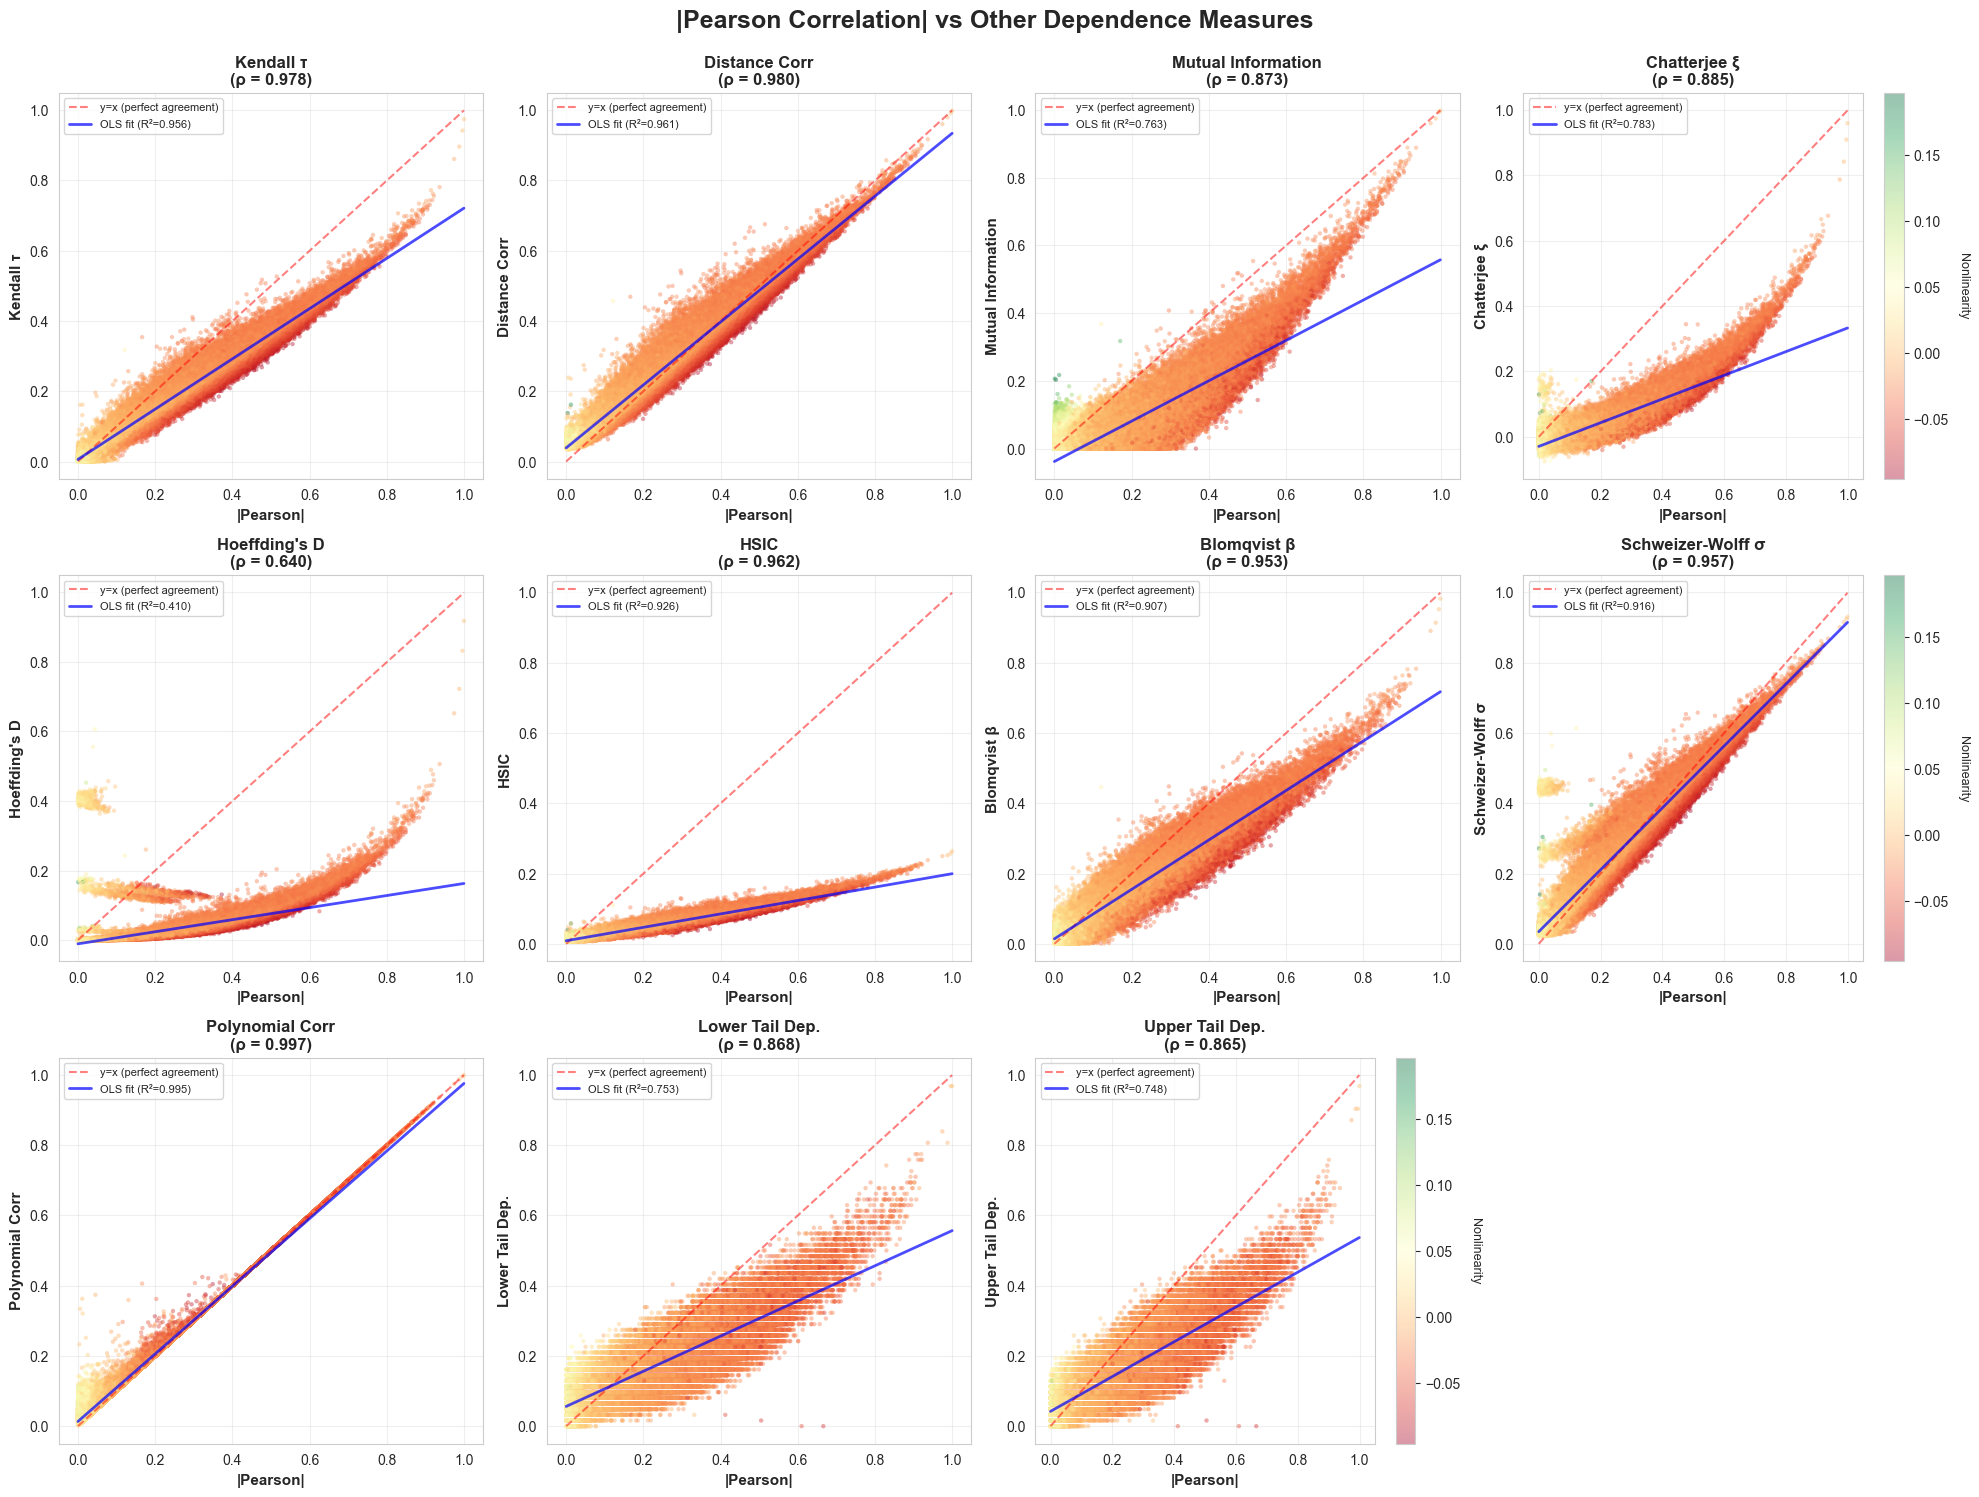


📈 Creating Spearman comparison plots...
💾 Saved: spearman_vs_all_measures.png


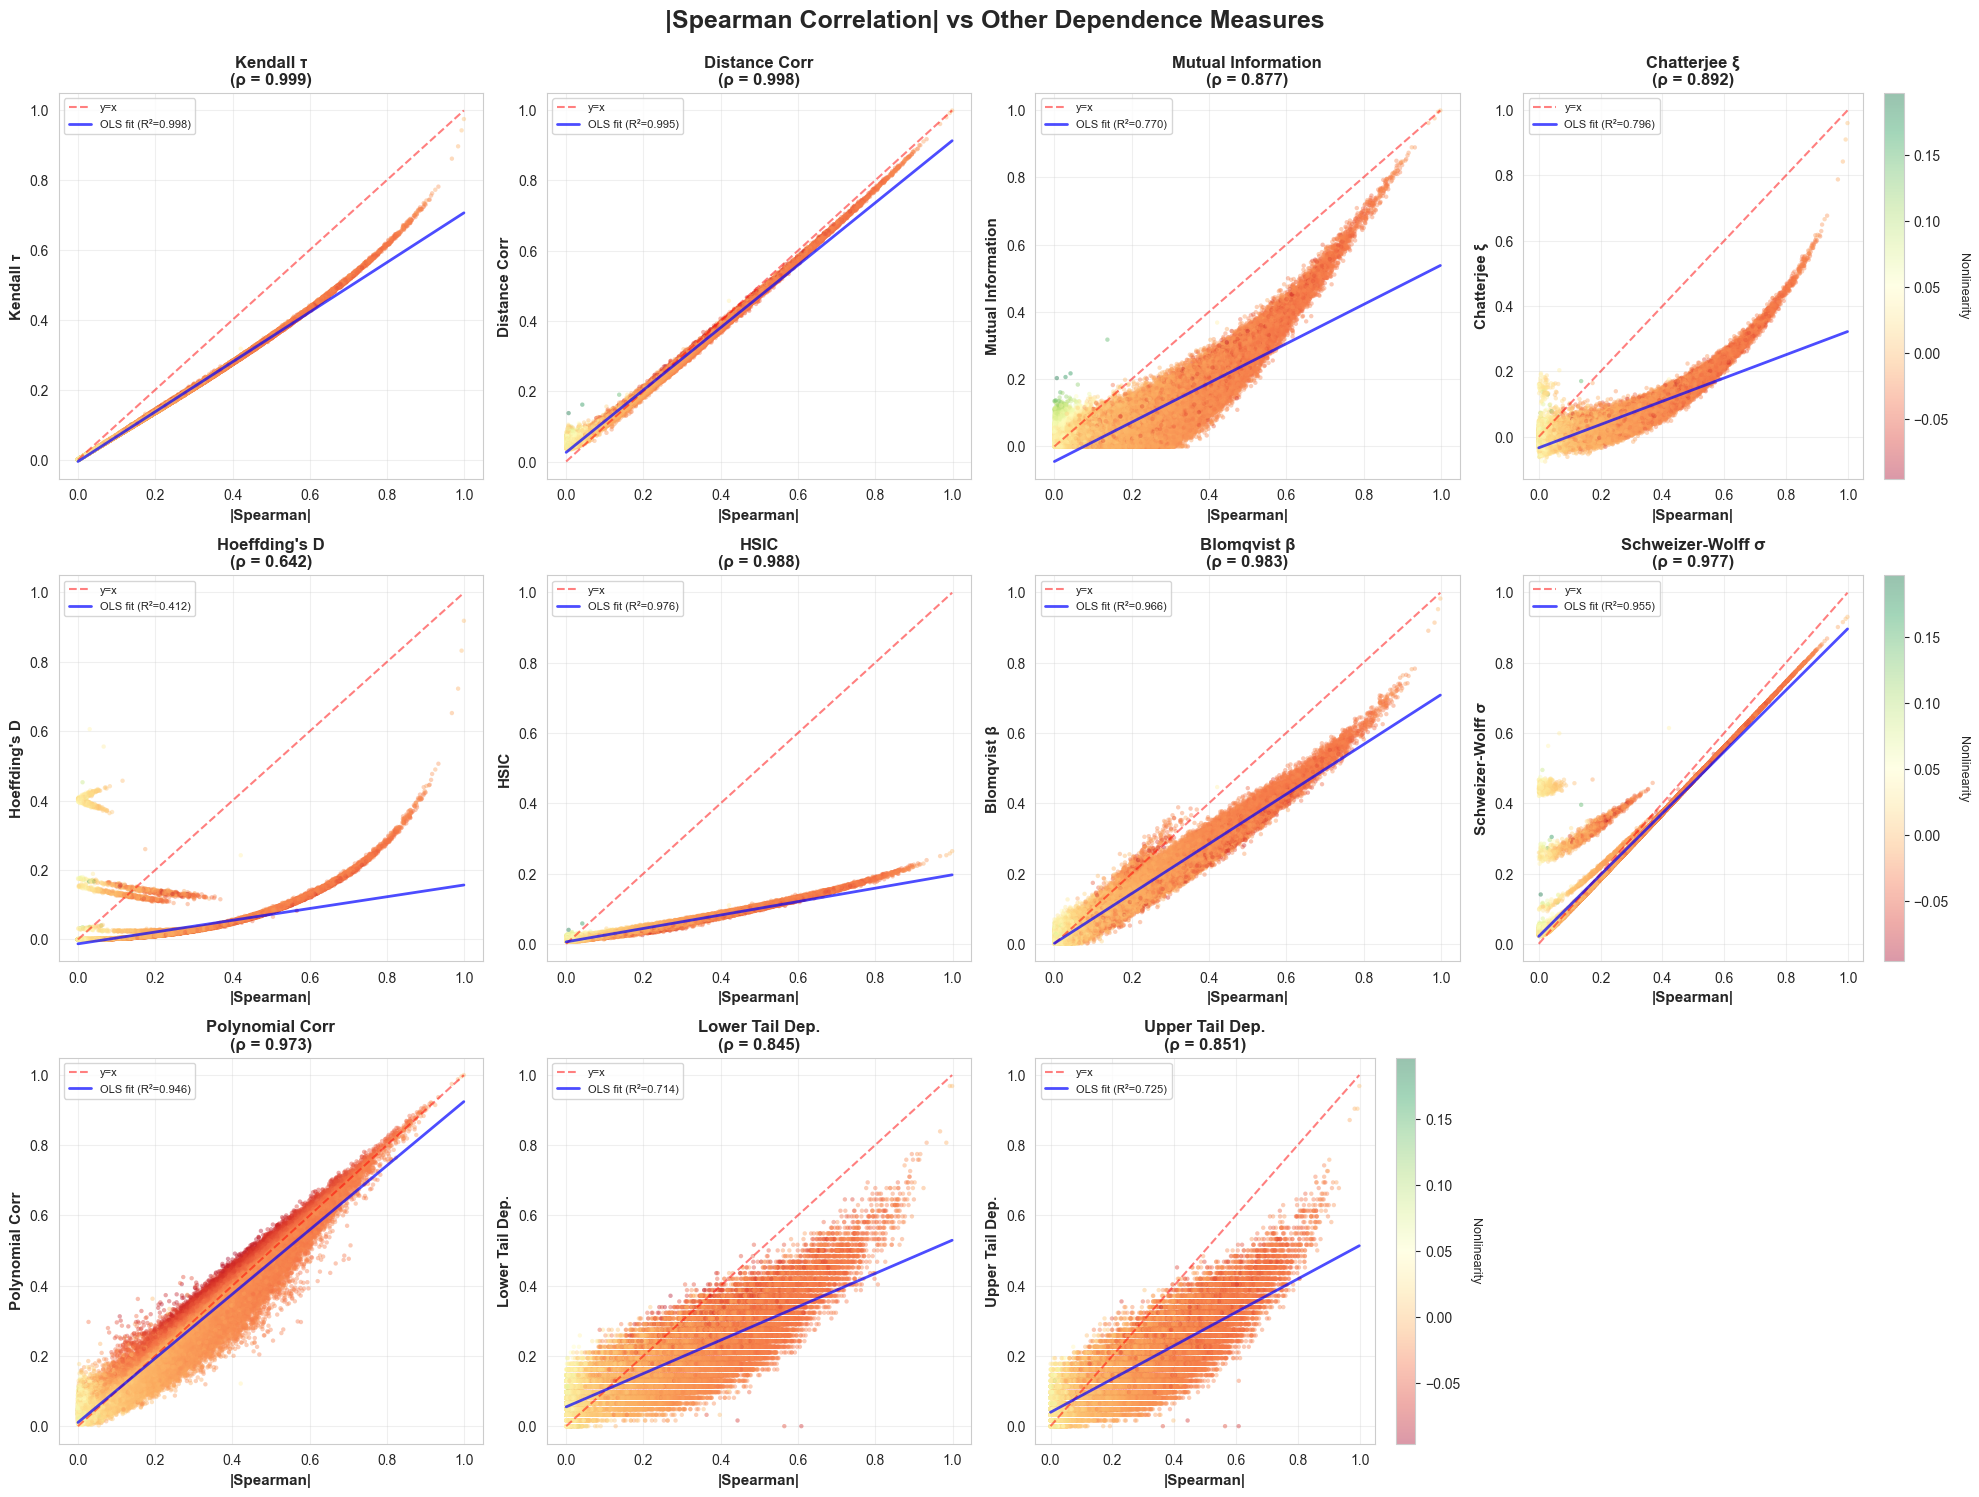


📈 Creating detailed comparison plots...
💾 Saved: detailed_linear_vs_nonlinear.png


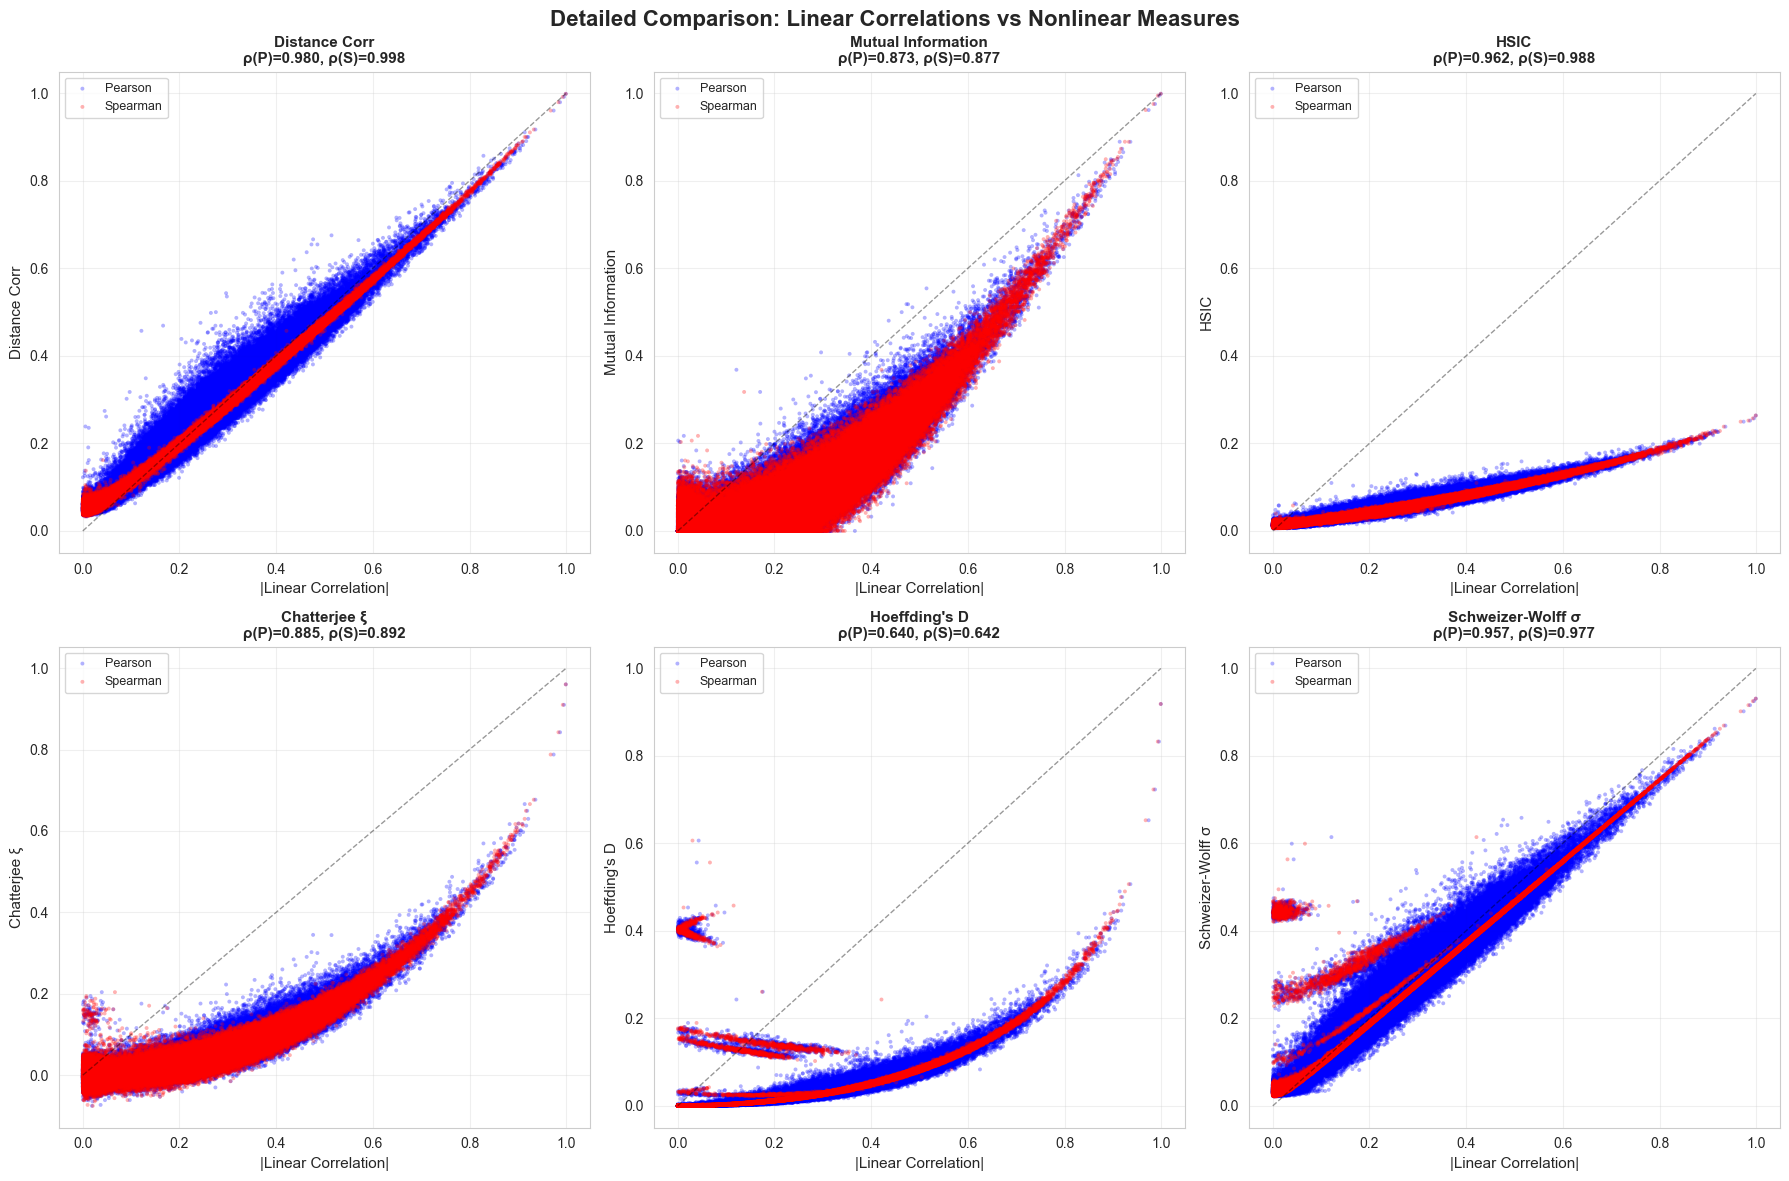


📈 Creating divergence analysis plots...
💾 Saved: divergence_analysis.png


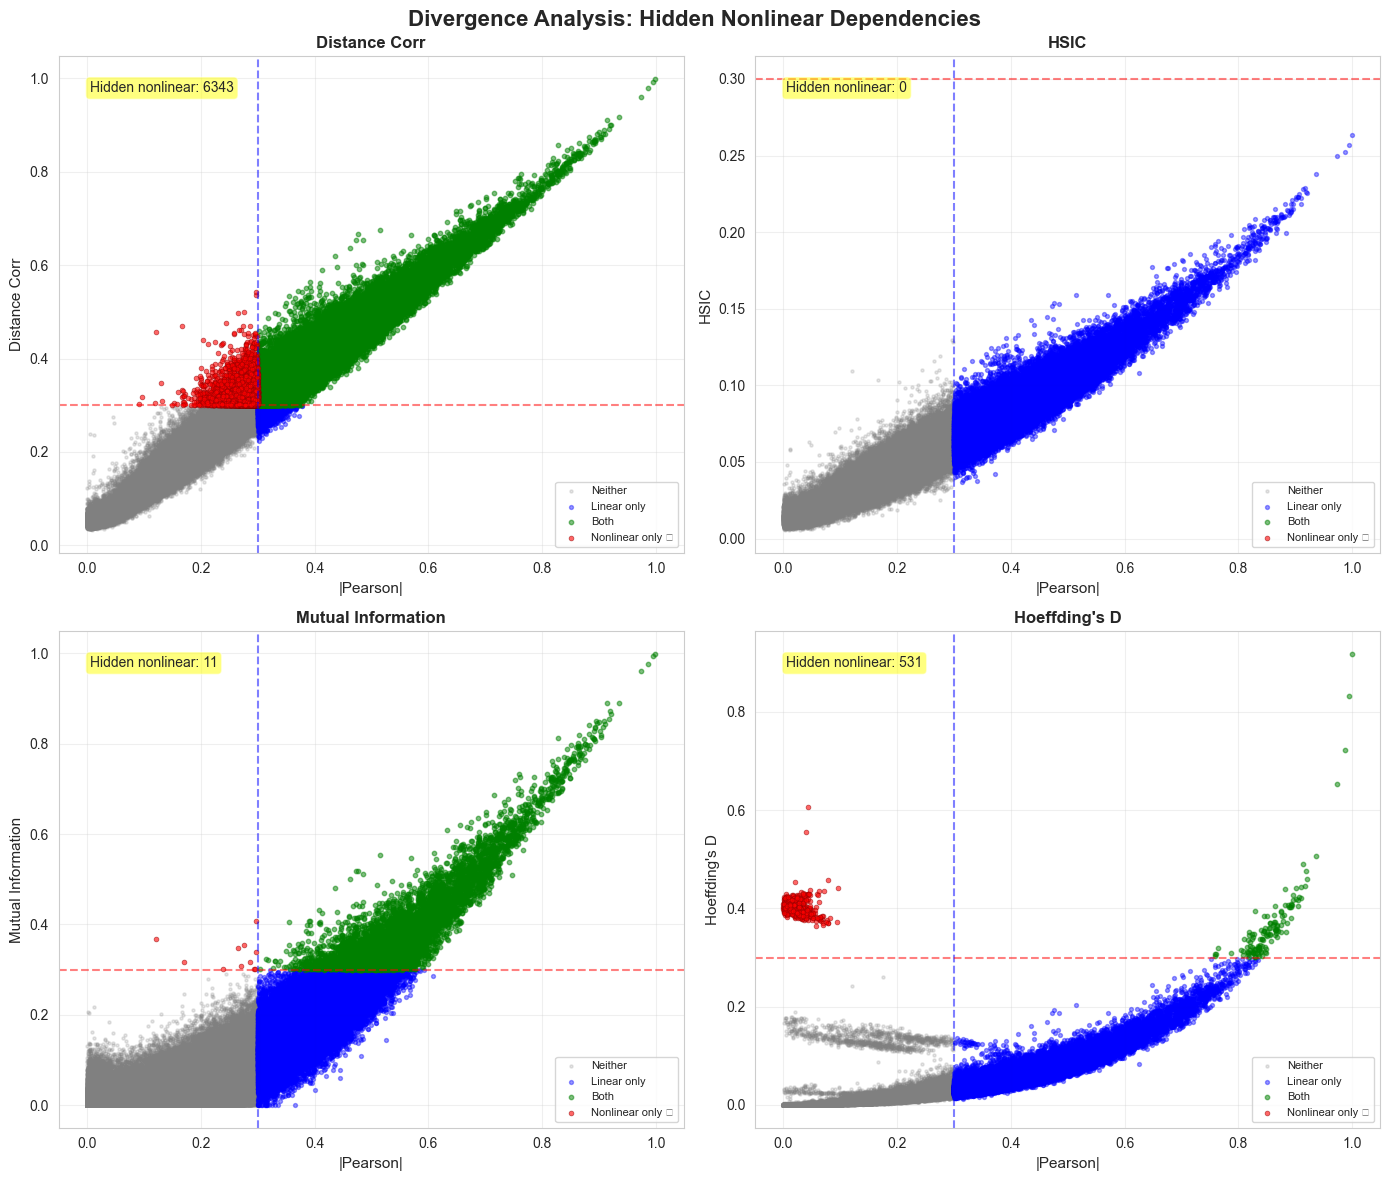


SUMMARY: CORRELATION BETWEEN MEASURES
           Measure ρ(Pearson) ρ(Spearman)  Divergent Pairs  Mean Median   Max
         Kendall τ      0.978       0.999                0 0.189  0.194 0.974
     Distance Corr      0.980       0.998                0 0.268  0.271 0.998
Mutual Information      0.873       0.877                1 0.115  0.094 0.999
      Chatterjee ξ      0.885       0.892                0 0.064  0.052 0.960
     Hoeffding's D      0.640       0.642              531 0.034  0.024 0.918
              HSIC      0.962       0.988                0 0.058  0.057 0.264
       Blomqvist β      0.953       0.983               30 0.195  0.199 0.982
 Schweizer-Wolff σ      0.957       0.977             1145 0.260  0.267 0.930
   Polynomial Corr      0.997       0.973               43 0.260  0.259 0.999
   Lower Tail Dep.      0.868       0.845               70 0.185  0.177 0.968
   Upper Tail Dep.      0.865       0.851               32 0.169  0.161 0.968

💾 Saved: measures_compar

In [36]:
# ============================================================================
# SCATTER PLOT VISUALIZATION: PEARSON & SPEARMAN vs ALL OTHER MEASURES
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# ============================================================================
# LOAD DATA
# ============================================================================

print("📊 Loading correlation data...")
df = pd.read_csv('financial_data_v2/all_correlations_comprehensive.csv')

print(f"Loaded {len(df):,} pairs with all correlation measures")

# ============================================================================
# DEFINE MEASURES TO COMPARE
# ============================================================================

# Reference measures (x-axis)
reference_measures = ['Pearson', 'Spearman']

# Other measures to compare against (y-axis)
comparison_measures = [
    'Kendall',
    'Distance',
    'MI',
    'Chatterjee',
    'Hoeffding',
    'HSIC',
    'Blomqvist',
    'SW_Sigma',
    'Poly_Corr',
    'Tail_Lower',
    'Tail_Upper'
]

# Nice names for plots
measure_names = {
    'Pearson': 'Pearson',
    'Spearman': 'Spearman',
    'Kendall': 'Kendall τ',
    'Distance': 'Distance Corr',
    'MI': 'Mutual Information',
    'Chatterjee': 'Chatterjee ξ',
    'Hoeffding': "Hoeffding's D",
    'HSIC': 'HSIC',
    'Blomqvist': 'Blomqvist β',
    'SW_Sigma': 'Schweizer-Wolff σ',
    'Poly_Corr': 'Polynomial Corr',
    'Tail_Lower': 'Lower Tail Dep.',
    'Tail_Upper': 'Upper Tail Dep.'
}

# ============================================================================
# PLOT 1: PEARSON vs ALL OTHERS
# ============================================================================

print("\n📈 Creating Pearson comparison plots...")

n_measures = len(comparison_measures)
n_cols = 4
n_rows = int(np.ceil(n_measures / n_cols))

fig = plt.figure(figsize=(20, 5*n_rows))
fig.suptitle('|Pearson Correlation| vs Other Dependence Measures', 
             fontsize=18, fontweight='bold', y=0.995)

for idx, measure in enumerate(comparison_measures, 1):
    ax = fig.add_subplot(n_rows, n_cols, idx)
    
    # Use absolute Pearson
    x = df['Pearson'].abs()
    
    # Use absolute for signed measures, raw for others
    if measure in ['Kendall', 'Blomqvist']:
        y = df[measure].abs()
    else:
        y = df[measure]
    
    # Color by Nonlinearity score
    colors = df['Nonlinearity'].fillna(0)
    
    # Scatter plot
    scatter = ax.scatter(x, y, c=colors, cmap='RdYlGn', 
                        alpha=0.4, s=10, edgecolors='none')
    
    # Add diagonal reference line
    max_val = max(x.max(), y.max())
    ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, linewidth=1.5, 
            label='y=x (perfect agreement)')
    
    # Regression line
    from scipy.stats import linregress
    mask = ~(np.isnan(x) | np.isnan(y))
    if mask.sum() > 10:
        slope, intercept, r_value, _, _ = linregress(x[mask], y[mask])
        line_x = np.array([x.min(), x.max()])
        line_y = slope * line_x + intercept
        ax.plot(line_x, line_y, 'b-', alpha=0.7, linewidth=2, 
                label=f'OLS fit (R²={r_value**2:.3f})')
    
    # Correlation between measures
    corr = np.corrcoef(x, y)[0, 1]
    
    # Styling
    ax.set_xlabel('|Pearson|', fontsize=11, fontweight='bold')
    ax.set_ylabel(measure_names[measure], fontsize=11, fontweight='bold')
    ax.set_title(f'{measure_names[measure]}\n(ρ = {corr:.3f})', 
                fontsize=12, fontweight='bold')
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Add colorbar only to last plot in each row
    if idx % n_cols == 0 or idx == n_measures:
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Nonlinearity', rotation=270, labelpad=15, fontsize=9)

plt.tight_layout()
plt.savefig('financial_data_v2/pearson_vs_all_measures.png', 
            dpi=150, bbox_inches='tight')
print("💾 Saved: pearson_vs_all_measures.png")
plt.show()

# ============================================================================
# PLOT 2: SPEARMAN vs ALL OTHERS
# ============================================================================

print("\n📈 Creating Spearman comparison plots...")

fig = plt.figure(figsize=(20, 5*n_rows))
fig.suptitle('|Spearman Correlation| vs Other Dependence Measures', 
             fontsize=18, fontweight='bold', y=0.995)

for idx, measure in enumerate(comparison_measures, 1):
    ax = fig.add_subplot(n_rows, n_cols, idx)
    
    # Use absolute Spearman
    x = df['Spearman'].abs()
    
    # Use absolute for signed measures
    if measure in ['Kendall', 'Blomqvist']:
        y = df[measure].abs()
    else:
        y = df[measure]
    
    # Color by Nonlinearity score
    colors = df['Nonlinearity'].fillna(0)
    
    # Scatter plot
    scatter = ax.scatter(x, y, c=colors, cmap='RdYlGn', 
                        alpha=0.4, s=10, edgecolors='none')
    
    # Diagonal line
    max_val = max(x.max(), y.max())
    ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, linewidth=1.5,
            label='y=x')
    
    # Regression line
    mask = ~(np.isnan(x) | np.isnan(y))
    if mask.sum() > 10:
        slope, intercept, r_value, _, _ = linregress(x[mask], y[mask])
        line_x = np.array([x.min(), x.max()])
        line_y = slope * line_x + intercept
        ax.plot(line_x, line_y, 'b-', alpha=0.7, linewidth=2,
                label=f'OLS fit (R²={r_value**2:.3f})')
    
    # Correlation
    corr = np.corrcoef(x, y)[0, 1]
    
    # Styling
    ax.set_xlabel('|Spearman|', fontsize=11, fontweight='bold')
    ax.set_ylabel(measure_names[measure], fontsize=11, fontweight='bold')
    ax.set_title(f'{measure_names[measure]}\n(ρ = {corr:.3f})', 
                fontsize=12, fontweight='bold')
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Colorbar
    if idx % n_cols == 0 or idx == n_measures:
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Nonlinearity', rotation=270, labelpad=15, fontsize=9)

plt.tight_layout()
plt.savefig('financial_data_v2/spearman_vs_all_measures.png', 
            dpi=150, bbox_inches='tight')
print("💾 Saved: spearman_vs_all_measures.png")
plt.show()

# ============================================================================
# PLOT 3: DETAILED COMPARISON - PEARSON vs SPEARMAN vs TOP MEASURES
# ============================================================================

print("\n📈 Creating detailed comparison plots...")

# Focus on most informative measures
key_measures = ['Distance', 'MI', 'HSIC', 'Chatterjee', 'Hoeffding', 'SW_Sigma']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Detailed Comparison: Linear Correlations vs Nonlinear Measures', 
             fontsize=16, fontweight='bold')

for idx, measure in enumerate(key_measures):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    x_pearson = df['Pearson'].abs()
    x_spearman = df['Spearman'].abs()
    y = df[measure]
    
    # Plot both Pearson and Spearman
    ax.scatter(x_pearson, y, alpha=0.3, s=8, c='blue', label='Pearson', edgecolors='none')
    ax.scatter(x_spearman, y, alpha=0.3, s=8, c='red', label='Spearman', edgecolors='none')
    
    # Diagonal
    max_val = max(x_pearson.max(), x_spearman.max(), y.max())
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.4, linewidth=1)
    
    # Correlations
    corr_p = np.corrcoef(x_pearson, y)[0, 1]
    corr_s = np.corrcoef(x_spearman, y)[0, 1]
    
    ax.set_xlabel('|Linear Correlation|', fontsize=11)
    ax.set_ylabel(measure_names[measure], fontsize=11)
    ax.set_title(f'{measure_names[measure]}\nρ(P)={corr_p:.3f}, ρ(S)={corr_s:.3f}',
                fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('financial_data_v2/detailed_linear_vs_nonlinear.png', 
            dpi=150, bbox_inches='tight')
print("💾 Saved: detailed_linear_vs_nonlinear.png")
plt.show()

# ============================================================================
# PLOT 4: DIVERGENCE ANALYSIS
# Points where nonlinear measures are high but linear are low
# ============================================================================

print("\n📈 Creating divergence analysis plots...")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Divergence Analysis: Hidden Nonlinear Dependencies', 
             fontsize=16, fontweight='bold')

# Define "interesting" regions
linear_threshold = 0.3  # Low linear correlation
nonlinear_threshold = 0.3  # High nonlinear measure

measures_to_analyze = ['Distance', 'HSIC', 'MI', 'Hoeffding']

for idx, measure in enumerate(measures_to_analyze):
    ax = axes[idx // 2, idx % 2]
    
    x = df['Pearson'].abs()
    y = df[measure]
    
    # Classify points
    is_linear = x > linear_threshold
    is_nonlinear = y > nonlinear_threshold
    
    # Four quadrants
    linear_only = is_linear & ~is_nonlinear
    nonlinear_only = ~is_linear & is_nonlinear
    both = is_linear & is_nonlinear
    neither = ~is_linear & ~is_nonlinear
    
    # Plot
    ax.scatter(x[neither], y[neither], c='gray', alpha=0.2, s=5, label='Neither')
    ax.scatter(x[linear_only], y[linear_only], c='blue', alpha=0.4, s=8, label='Linear only')
    ax.scatter(x[both], y[both], c='green', alpha=0.5, s=10, label='Both')
    ax.scatter(x[nonlinear_only], y[nonlinear_only], c='red', alpha=0.6, s=12, 
               label='Nonlinear only ⭐', edgecolors='darkred', linewidths=0.5)
    
    # Threshold lines
    ax.axvline(x=linear_threshold, color='blue', linestyle='--', alpha=0.5, linewidth=1.5)
    ax.axhline(y=nonlinear_threshold, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    
    # Annotate counts
    n_nonlinear_only = nonlinear_only.sum()
    ax.text(0.05, 0.95, f'Hidden nonlinear: {n_nonlinear_only}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
    
    ax.set_xlabel('|Pearson|', fontsize=11)
    ax.set_ylabel(measure_names[measure], fontsize=11)
    ax.set_title(measure_names[measure], fontsize=12, fontweight='bold')
    ax.legend(fontsize=8, loc='lower right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('financial_data_v2/divergence_analysis.png', 
            dpi=150, bbox_inches='tight')
print("💾 Saved: divergence_analysis.png")
plt.show()

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("\n" + "="*80)
print("SUMMARY: CORRELATION BETWEEN MEASURES")
print("="*80)

summary_data = []

for measure in comparison_measures:
    y = df[measure].abs() if measure in ['Kendall', 'Blomqvist'] else df[measure]
    
    corr_pearson = np.corrcoef(df['Pearson'].abs(), y)[0, 1]
    corr_spearman = np.corrcoef(df['Spearman'].abs(), y)[0, 1]
    
    # Find "divergence" - pairs where linear is low but nonlinear is high
    divergent = ((df['Pearson'].abs() < 0.3) & (df['Spearman'].abs() < 0.3) & (y > 0.3)).sum()
    
    summary_data.append({
        'Measure': measure_names[measure],
        'ρ(Pearson)': f'{corr_pearson:.3f}',
        'ρ(Spearman)': f'{corr_spearman:.3f}',
        'Divergent Pairs': divergent,
        'Mean': f'{y.mean():.3f}',
        'Median': f'{y.median():.3f}',
        'Max': f'{y.max():.3f}'
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv('financial_data_v2/measures_comparison_summary.csv', index=False)
print("\n💾 Saved: measures_comparison_summary.csv")

print("\n" + "="*80)
print("✅ ALL PLOTS CREATED SUCCESSFULLY!")
print("="*80)
print("\nGenerated files:")
print("  📊 pearson_vs_all_measures.png")
print("  📊 spearman_vs_all_measures.png")
print("  📊 detailed_linear_vs_nonlinear.png")
print("  📊 divergence_analysis.png")
print("  📄 measures_comparison_summary.csv")


# Cointegration

📊 Loading data...
Assets: 533
Total pairs: 141,778

🔄 Running Johansen cointegration test on 141,778 pairs...
This may take 10-30 minutes...



Testing: 100%|██████████| 141778/141778 [01:12<00:00, 1959.60it/s]



JOHANSEN COINTEGRATION TEST RESULTS

Total pairs tested: 141,778
Errors: 0

Cointegrated pairs:
  At 90% confidence: 31,623 (22.30%)
  At 95% confidence: 19,132 (13.49%)
  At 99% confidence: 6,492 (4.58%)

TOP 30 COINTEGRATED PAIRS (95% confidence, sorted by trace statistic)
               Pair  trace_stat  trace_crit_95  eigen_stat   hedge_ratio
RUBUSD=X — SARUSD=X  633.795107        15.4943  420.844459 -7.205324e+00
AEDUSD=X — RUBUSD=X  549.912886        15.4943  386.344383 -3.553326e-02
      DG — RUBUSD=X  451.566325        15.4943  450.488661  3.474469e+04
     CHD — RUBUSD=X  449.082219        15.4943  444.941581 -6.519426e+03
    CPRT — RUBUSD=X  448.232118        15.4943  445.957698 -7.021403e+03
     ROP — RUBUSD=X  447.991295        15.4943  444.416929 -4.040539e+04
    BLDR — RUBUSD=X  447.935389        15.4943  445.456702 -3.272977e+04
     LEN — RUBUSD=X  444.547226        15.4943  441.894238 -2.036847e+04
    EQIX — RUBUSD=X  443.898724        15.4943  438.095180 -6.5552

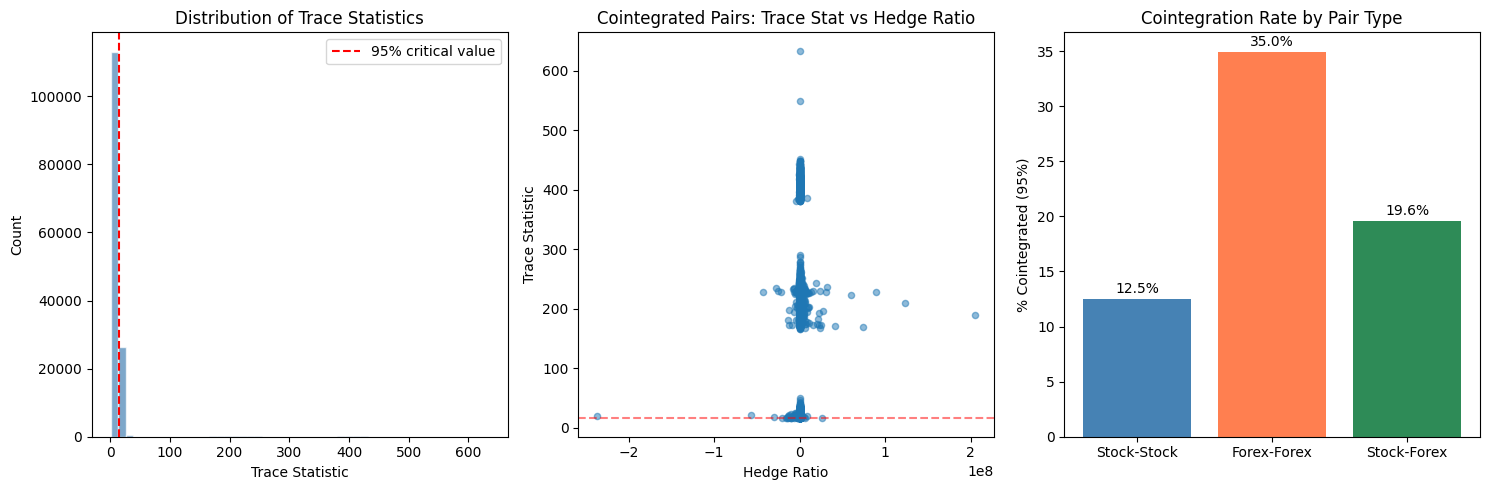


💾 Saved: johansen_results.png


In [30]:
# ============================================================================
# JOHANSEN COINTEGRATION TEST FOR ALL PAIRS
# ============================================================================

import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from itertools import combinations
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# LOAD DATA (prices, not returns - cointegration uses levels)
# ============================================================================

print("📊 Loading data...")
df = pd.read_pickle('financial_data_v2/market_data_clean.pkl')

# Remove any remaining NaN
df = df.dropna(axis=1, how='any')

columns = df.columns.tolist()
n_cols = len(columns)
total_pairs = n_cols * (n_cols - 1) // 2

print(f"Assets: {n_cols}")
print(f"Total pairs: {total_pairs:,}")

# ============================================================================
# JOHANSEN TEST FUNCTION
# ============================================================================

def johansen_test(series1, series2, det_order=0, k_ar_diff=1):
    """
    Perform Johansen cointegration test on two series.
    
    Parameters:
    -----------
    series1, series2 : array-like
        Price series (levels, not returns)
    det_order : int
        -1: no deterministic terms
         0: constant term (most common for financial data)
         1: constant + trend
    k_ar_diff : int
        Number of lagged differences in the model
    
    Returns:
    --------
    dict with test results
    """
    try:
        # Combine into matrix
        data = np.column_stack([series1, series2])
        
        # Run Johansen test
        result = coint_johansen(data, det_order=det_order, k_ar_diff=k_ar_diff)
        
        # Trace statistic
        trace_stat = result.lr1[0]  # Test for r=0 (no cointegration)
        trace_crit_90 = result.cvt[0, 0]  # 90% critical value
        trace_crit_95 = result.cvt[0, 1]  # 95% critical value
        trace_crit_99 = result.cvt[0, 2]  # 99% critical value
        
        # Max eigenvalue statistic
        eigen_stat = result.lr2[0]
        eigen_crit_90 = result.cvm[0, 0]
        eigen_crit_95 = result.cvm[0, 1]
        eigen_crit_99 = result.cvm[0, 2]
        
        # Cointegration vector (hedge ratio)
        # Normalized so first coefficient = 1
        coint_vector = result.evec[:, 0]
        hedge_ratio = -coint_vector[1] / coint_vector[0]
        
        return {
            'trace_stat': trace_stat,
            'trace_crit_90': trace_crit_90,
            'trace_crit_95': trace_crit_95,
            'trace_crit_99': trace_crit_99,
            'eigen_stat': eigen_stat,
            'eigen_crit_90': eigen_crit_90,
            'eigen_crit_95': eigen_crit_95,
            'eigen_crit_99': eigen_crit_99,
            'hedge_ratio': hedge_ratio,
            'coint_90': trace_stat > trace_crit_90,
            'coint_95': trace_stat > trace_crit_95,
            'coint_99': trace_stat > trace_crit_99,
            'error': None
        }
    except Exception as e:
        return {
            'trace_stat': np.nan,
            'trace_crit_90': np.nan,
            'trace_crit_95': np.nan,
            'trace_crit_99': np.nan,
            'eigen_stat': np.nan,
            'eigen_crit_90': np.nan,
            'eigen_crit_95': np.nan,
            'eigen_crit_99': np.nan,
            'hedge_ratio': np.nan,
            'coint_90': False,
            'coint_95': False,
            'coint_99': False,
            'error': str(e)
        }

# ============================================================================
# RUN TEST ON ALL PAIRS
# ============================================================================

print(f"\n🔄 Running Johansen cointegration test on {total_pairs:,} pairs...")
print("This may take 10-30 minutes...\n")

results = []

for i, j in tqdm(combinations(range(n_cols), 2), total=total_pairs, desc="Testing"):
    col1, col2 = columns[i], columns[j]
    
    series1 = df[col1].values
    series2 = df[col2].values
    
    test_result = johansen_test(series1, series2)
    
    results.append({
        'Asset1': col1,
        'Asset2': col2,
        'Pair': f"{col1} — {col2}",
        **test_result
    })

df_results = pd.DataFrame(results)

# ============================================================================
# ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("JOHANSEN COINTEGRATION TEST RESULTS")
print("="*80)

# Count cointegrated pairs at different significance levels
n_coint_90 = df_results['coint_90'].sum()
n_coint_95 = df_results['coint_95'].sum()
n_coint_99 = df_results['coint_99'].sum()
n_errors = df_results['error'].notna().sum()

print(f"\nTotal pairs tested: {len(df_results):,}")
print(f"Errors: {n_errors}")
print(f"\nCointegrated pairs:")
print(f"  At 90% confidence: {n_coint_90:,} ({100*n_coint_90/len(df_results):.2f}%)")
print(f"  At 95% confidence: {n_coint_95:,} ({100*n_coint_95/len(df_results):.2f}%)")
print(f"  At 99% confidence: {n_coint_99:,} ({100*n_coint_99/len(df_results):.2f}%)")

# ============================================================================
# TOP COINTEGRATED PAIRS
# ============================================================================

# Sort by trace statistic (higher = stronger evidence of cointegration)
df_coint = df_results[df_results['coint_95'] == True].copy()
df_coint = df_coint.sort_values('trace_stat', ascending=False)

print("\n" + "="*80)
print("TOP 30 COINTEGRATED PAIRS (95% confidence, sorted by trace statistic)")
print("="*80)

if len(df_coint) > 0:
    display_cols = ['Pair', 'trace_stat', 'trace_crit_95', 'eigen_stat', 'hedge_ratio']
    print(df_coint[display_cols].head(30).to_string(index=False))
else:
    print("No cointegrated pairs found at 95% confidence level.")

# ============================================================================
# CATEGORIZE BY ASSET TYPE
# ============================================================================

print("\n" + "="*80)
print("COINTEGRATION BY ASSET TYPE (95% confidence)")
print("="*80)

def get_pair_type(row):
    a1, a2 = row['Asset1'], row['Asset2']
    is_fx1 = '=X' in a1
    is_fx2 = '=X' in a2
    if is_fx1 and is_fx2:
        return 'Forex-Forex'
    elif not is_fx1 and not is_fx2:
        return 'Stock-Stock'
    else:
        return 'Stock-Forex'

df_results['PairType'] = df_results.apply(get_pair_type, axis=1)

for pair_type in ['Stock-Stock', 'Forex-Forex', 'Stock-Forex']:
    subset = df_results[df_results['PairType'] == pair_type]
    n_coint = subset['coint_95'].sum()
    print(f"{pair_type:15s}: {n_coint:5d} / {len(subset):6d} cointegrated ({100*n_coint/len(subset):.2f}%)")

# ============================================================================
# SAVE RESULTS
# ============================================================================

# All results
df_results.to_csv('financial_data_v2/johansen_all_pairs.csv', index=False)

# Only cointegrated pairs
df_coint.to_csv('financial_data_v2/johansen_cointegrated_pairs.csv', index=False)

print(f"\n💾 Saved:")
print(f"   - johansen_all_pairs.csv ({len(df_results):,} pairs)")
print(f"   - johansen_cointegrated_pairs.csv ({len(df_coint):,} pairs)")

# ============================================================================
# VISUALIZATION
# ============================================================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Distribution of trace statistics
ax = axes[0]
ax.hist(df_results['trace_stat'].dropna(), bins=50, color='steelblue', edgecolor='white', alpha=0.7)
ax.axvline(x=df_results['trace_crit_95'].mean(), color='red', linestyle='--', label='95% critical value')
ax.set_xlabel('Trace Statistic')
ax.set_ylabel('Count')
ax.set_title('Distribution of Trace Statistics')
ax.legend()

# 2. Trace stat vs Hedge ratio for cointegrated pairs
ax = axes[1]
if len(df_coint) > 0:
    ax.scatter(df_coint['hedge_ratio'], df_coint['trace_stat'], alpha=0.5, s=20)
    ax.set_xlabel('Hedge Ratio')
    ax.set_ylabel('Trace Statistic')
    ax.set_title('Cointegrated Pairs: Trace Stat vs Hedge Ratio')
    ax.axhline(y=df_results['trace_crit_95'].mean(), color='red', linestyle='--', alpha=0.5)

# 3. Cointegration by pair type
ax = axes[2]
pair_types = ['Stock-Stock', 'Forex-Forex', 'Stock-Forex']
coint_counts = [df_results[(df_results['PairType'] == pt) & (df_results['coint_95'])].shape[0] for pt in pair_types]
total_counts = [df_results[df_results['PairType'] == pt].shape[0] for pt in pair_types]
coint_pcts = [100 * c / t if t > 0 else 0 for c, t in zip(coint_counts, total_counts)]

bars = ax.bar(pair_types, coint_pcts, color=['steelblue', 'coral', 'seagreen'])
ax.set_ylabel('% Cointegrated (95%)')
ax.set_title('Cointegration Rate by Pair Type')
for bar, pct in zip(bars, coint_pcts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{pct:.1f}%', ha='center')

plt.tight_layout()
plt.savefig('financial_data_v2/johansen_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💾 Saved: johansen_results.png")
